In [16]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

import zenhan
import MeCab

import torch

from transformers import BertJapaneseTokenizer
from transformers import BertModel

import tensorflow
import keras
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
# from keras.models import Model, Input, load_model
from tensorflow.keras import Input
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling1D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

pd.set_option("display.max_columns", None)

# テキスト解析（文書分類）

- 適用先
  - コールセンターなどに対する問い合わせを自動的に分類する
  - 問い合わせと類似したものを自動でレコメンドする
- 適用技術
  - BERT(Bidirectional Encoder Representations from Transformers)
    - （トランスフォーマーによる双方向エンコーダ表現）
- BERTを文書分類に適用した例

### 4-6-1 目的変数の例

### 4-6-2 分析方針の設計

- 教師あり学習
  - テキスト分類
    - 問い合わせ自動分類

### 4-6-3 データ加工

- ファイルの読み込み
- 質問文とラベルの結合
- 学習用データと評価法データの分離
- [京都大学 BERT-based FAQ Retrieval Model](http:nlp.ist.i.kyoto-u.ac.jp/index.php?BERT-Based_FAQ_Retrieval)

#### ファイルの読み込み

- 尼崎市のオープンデータの質問文を読み込む。
- 手動で作成したラベルのデータを読み込む。
  - ラベルは各分類に対し0,1を記載。(1が、その分類に当てはまることを意味する)
- データに手動で作成したラベルを結合する。

In [2]:
df_question = pd.read_csv(
    "./data/localgovfaq/qas/questions_in_Amagasaki.txt",
    header=None,
    sep="\t"
)
df_question.columns = ["index", "text"]

print(df_question.shape)
display(df_question)

(1786, 2)


,index,text
0,0,乳幼児 と その 親 が 集う 場 、 地域 の 母親 同士 の 情報 交換 や 交流 の ...
1,1,地域 総合 センター 今 北 へ は どう 行けば いい です か ？
2,2,市外 から 尼崎 市 内 へ 住所 を 移す とき は どう したら いい です か ？ （...
3,3,尼崎 市 内 の 事業 系 ごみ の 直接 搬入 に ついて 知り たい 。
4,4,【 特定 健診 】 ハーティ ２１ （ 人間ドック を 実施 して いた 場所 ） で 健診...
...,...,...
1781,1781,尼崎 市 の 草花 は 何 です か 。
1782,1782,【 キャラクター 】 「 あま っこ 」 に ついて
1783,1783,尼崎 市 は どこ に あり ます か 。
1784,1784,ゴミ の 出し 方 に ついて 教えて


In [6]:
# 尼崎市のオープンデータに手動でラベル付けしたデータ
filename = "sample_input_amagasaki_label.csv"

df_label = pd.read_csv(
    "../../support/src1300/src_ch04/4.6_文章分類/data/" + filename
)

df_label = df_label.fillna(0)
print(df_label.shape)
display(df_label)

(1786, 16)


,戸籍・住民票・印鑑登録,福祉,保険・医療・年金,税金,こども・青少年・教育,住まいとくらし,学ぶ・遊ぶ,環境・緑化・動物,しごと・産業,健康・衛生,市政・市の仕組み,市民参画とまちづくり,道路・住宅・都市整備,特定健康調査,防災,その他
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


16種類のラベル

|#|ラベル|#|ラベル|
|:-:|:-:|:-:|:-:|
|1|戸籍・住民票・印鑑登録|9|しごと・産業|
|2|福祉|10|健康・衛生|
|3|保険・医療・年金|11|市政・市の仕組み|
|4|税金|12|市民参画とまちづくり|
|5|こども・青少年・教育|13|道路・住宅・都市整備|
|6|住まいとくらし|14|特定健康調査|
|7|学ぶ・遊ぶ|15|防災|
|8|環境・緑化・動物|16|その他|

In [7]:
# 質問文とラベルの結合
df = pd.concat([df_question, df_label], axis=1)
display(df)

,index,text,戸籍・住民票・印鑑登録,福祉,保険・医療・年金,税金,こども・青少年・教育,住まいとくらし,学ぶ・遊ぶ,環境・緑化・動物,しごと・産業,健康・衛生,市政・市の仕組み,市民参画とまちづくり,道路・住宅・都市整備,特定健康調査,防災,その他
0,0,乳幼児 と その 親 が 集う 場 、 地域 の 母親 同士 の 情報 交換 や 交流 の ...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,地域 総合 センター 今 北 へ は どう 行けば いい です か ？,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,市外 から 尼崎 市 内 へ 住所 を 移す とき は どう したら いい です か ？ （...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,尼崎 市 内 の 事業 系 ごみ の 直接 搬入 に ついて 知り たい 。,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,【 特定 健診 】 ハーティ ２１ （ 人間ドック を 実施 して いた 場所 ） で 健診...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781,1781,尼崎 市 の 草花 は 何 です か 。,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1782,1782,【 キャラクター 】 「 あま っこ 」 に ついて,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1783,1783,尼崎 市 は どこ に あり ます か 。,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1784,1784,ゴミ の 出し 方 に ついて 教えて,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# train/test に分離
df_train, df_test = train_test_split(
    df, train_size=0.8, random_state=123
)
print(df_train.shape, df_test.shape)

# インデックスの振り直し
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

(1428, 18) (358, 18)


学習用データの分類数: 16
評価用データの分類数: 16


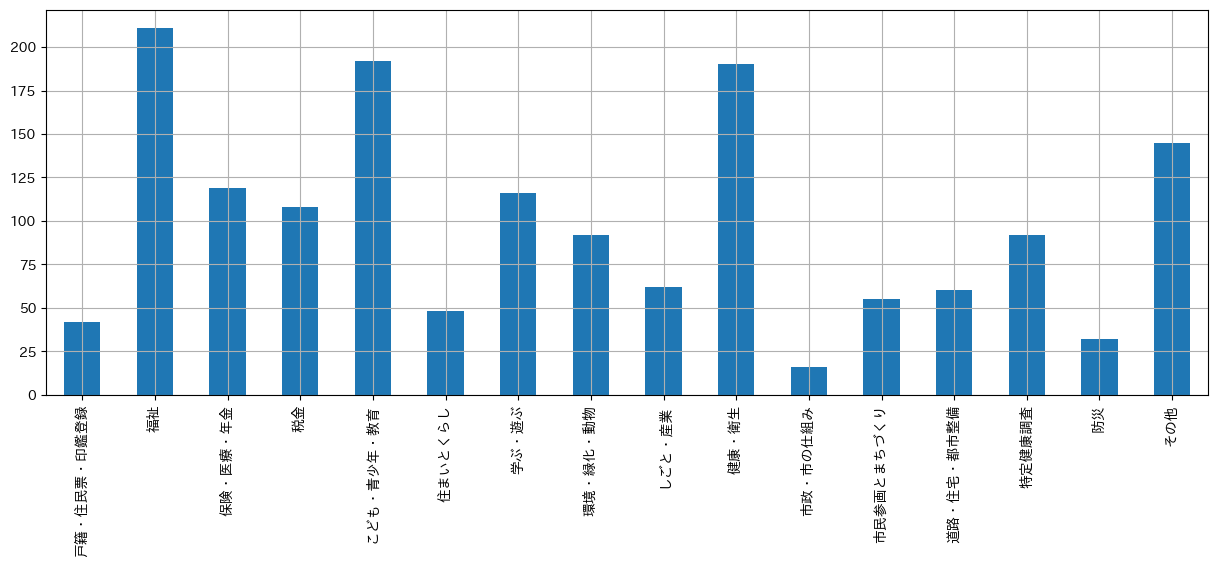

In [18]:
# 学習用データと評価用データに偏りがないか確認する
list_category = list(df_train.columns[2:18])
print("学習用データの分類数: {}".format(len(list_category)))
list_category_test = list(df_test.columns[2:18])
print("評価用データの分類数: {}".format(len(list_category_test)))

plt.rcParams["font.family"] = "IPAexGothic"

# 学習用データの分布
plt.figure(figsize=(15, 5))
df_train[list_category].agg("sum").plot.bar()
plt.grid()

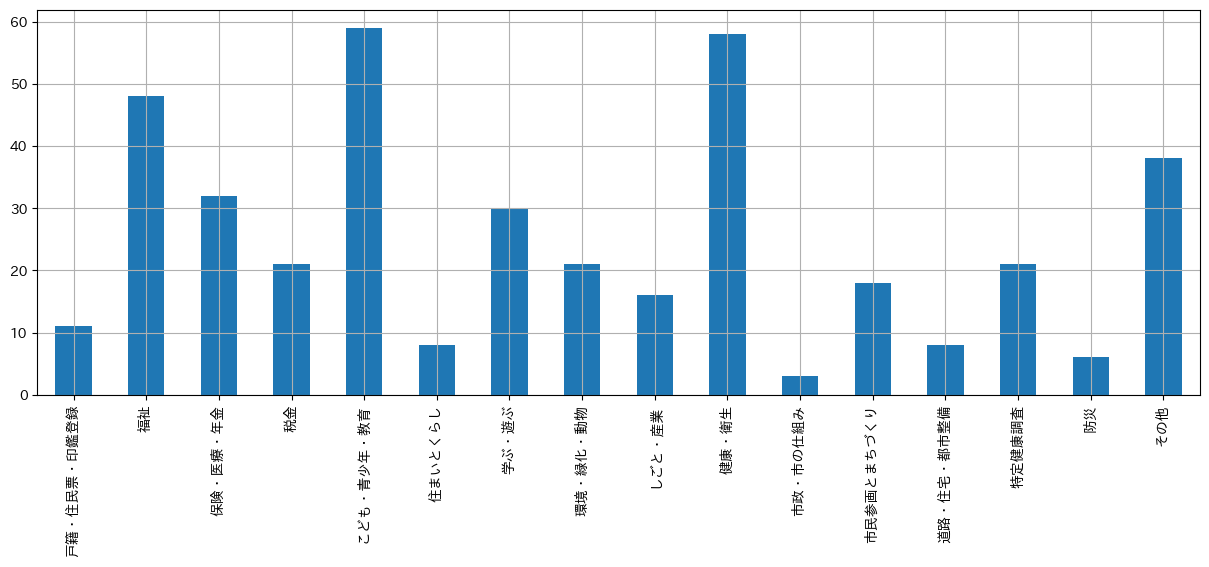

In [19]:
# 検証用データの分布
plt.figure(figsize=(15, 5))
df_test[list_category].agg("sum").plot.bar()
plt.grid()

### 4-6-4 データ分析・モデリング、および分析モデルの精度評価

- アルファベットや数字などの全角・半角の表記のゆれを統一
- 空白の削除

####   データ前処理加工

- テキストの前処理
    - ここではテキストの簡単な前処理を行なっている。
    - 具体的には，「全角から半角への変換」「空白削除」の2つ。
    - このほかにも不要な記号等の削除，stopwordの削除など必要に応じて実施。
- 形態素解析
    - 日本語の場合，英語と違ってスペースで単語が区切れていないため，形態素解析と呼ばれる方法で単語に分割する。
    - MeCabやchasenといった有名なツールを用いると簡単に実施可能。
- ベクトル表現への変換
    - 機械学習のモデルが解釈できるように数値(ベクトル表現)に変換する。
    - BERTはモデルを利用しており，このモデル自体を新規に学習させたり，学習済モデルを転移学習することも可能。
    - 本サンプルコードでは学習させないケースで説明する。
    - 学習済モデルは良くできているので，そのまま使うケースも多い。

In [20]:
# 変換: 全角->半角
def z2h(text):
    text = zenhan.z2h(text)
    return text

# 空白削除
def del_space(text):
    text = text.replace(" ", "")
    return text

# 前処理関数
def preprocess_text(text):
    text = z2h(text)
    text = del_space(text)
    return text

#### BERTで使用する事前学習済みモデルの読み込み

- 東北大学で作成されたモデル
  - bert-base-japanese-whole-word-masking
  - <https:github.com/cl-tohoku/bert-japanese>

In [ ]:
# BERT
# トークナイザー